In [1]:
# import library
import pandas as pd
from scipy.sparse import load_npz
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve
from sklearn.ensemble import BaggingClassifier

In [2]:
#import data after preprocessing
train_df = pd.read_csv("./project_data_files/book_rating_train.csv")
test_df = pd.read_csv("./project_data_files/book_rating_test.csv")
X_train = load_npz('x_train_1000.npz')
X_test = load_npz('x_test_1000.npz')
y_train = train_df['rating_label']

In [3]:
# split train and testing dataset
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print(X_train.shape)

(18450, 1000)


In [4]:
def output_predictions(prediction):
    #output result
    output_df = pd.DataFrame({'rating_label': prediction})
    output_df.index += 1
    output_df.index.name = 'id'
    output_df.to_csv('./predictions.csv')
    return

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
import warnings

warnings.simplefilter(action='ignore', category=UserWarning)


In [21]:
from sklearn.model_selection import GridSearchCV


# Define the parameter grid to search over
param_grid = {'max_iter': list(range(100,1000,100))
              }

# Create a logistic regression classifier
lgr = LogisticRegression(multi_class='multinomial', warm_start=True, n_jobs=-1)


# Use GridSearchCV to find the best max_iter value
grid_search = GridSearchCV(lgr, param_grid, cv=3)
grid_search.fit(X_train, y_train)


GridSearchCV(cv=3,
             estimator=LogisticRegression(multi_class='multinomial', n_jobs=-1,
                                          warm_start=True),
             param_grid={'max_iter': [100, 200, 300, 400, 500, 600, 700, 800,
                                      900]})

In [22]:
# Print the best parameters and accuracy score
print("Best max_iter value:", grid_search.best_params_)
print("Accuracy:", grid_search.score(X_val, y_val))

Best max_iter value: {'max_iter': 900}
Accuracy: 0.7186212876652938


In [6]:
lgr = BaggingClassifier(LogisticRegressionCV(Cs=[0.001, 0.01, 0.1, 1, 5, 10,100], solver = 'lbfgs', multi_class='multinomial', max_iter=900,cv=3), n_estimators=50, max_features=0.9)
lgr.fit(X_train,y_train)
print("Accuracy:",lgr.score(X_val,y_val))
prediction_logistic = lgr.predict(X_test)
output_predictions(prediction_logistic)

Accuracy: 0.7114675915889876


In [28]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(10,7))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
 
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
 
    plt.legend(loc="best")
    return plt


<module 'matplotlib.pyplot' from 'C:\\Users\\Olivia\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python310\\site-packages\\matplotlib\\pyplot.py'>

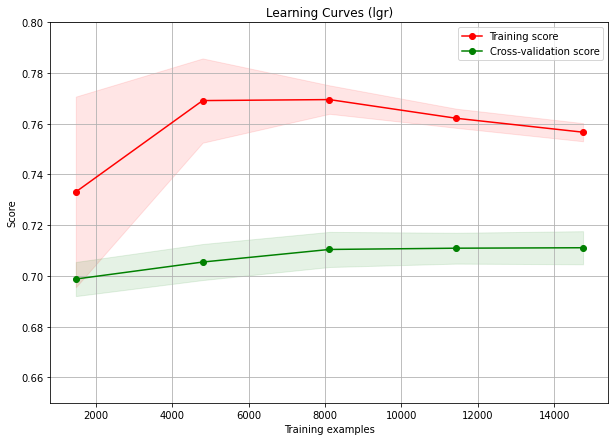

In [29]:
title = r"Learning Curves (lgr)"
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = lgr    #建模
plot_learning_curve(estimator, title, X_train, y_train, ylim=(0.65, 0.8), cv=cv, n_jobs=1)

In [16]:
prediction_logistic_grid = grid_search.predict(X_test)
output_predictions(prediction_logistic_grid)

NameError: name 'grid_search' is not defined